In [89]:
import math

import matplotlib.pyplot as plt
import numpy as np
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from keras.models import load_model

import matplotlib.pyplot as plt

import random
import tifffile
import os

In [3]:
eval_folder_list = ["../jupyter_data/eval/c1", "../jupyter_data/eval/c2", "../jupyter_data/eval/c3"]


In [4]:
from read_roi import read_roi_zip


def read_roi(roi_path):
    roi = read_roi_zip(roi_path)
    roi_coords = []
    for i, v in enumerate(roi.values()):
        if v['type'] == 'rectangle':
            roi_x, roi_y = v['left'], v['top']
            roi_width, roi_height = v['width'], v['height']
            roi_coords.append([roi_x, roi_y, roi_width, roi_height])
    return roi_coords


In [5]:
eval_data_list = []
eval_tifpath_list = []
for channel_folder in eval_folder_list:
    for folder in os.listdir(channel_folder):
        image_folder = os.path.join(channel_folder, folder)
        files_list = os.listdir(image_folder)
        files_list = [os.path.join(image_folder, file) for file in files_list]
        if len(files_list) != 2:
            print("Number of files is not 2.")
            continue
        golgi_dict = {}
        if files_list[0].endswith("tif"):
            tif_path, roi_path = files_list
        else:
            roi_path, tif_path = files_list
        eval_tifpath_list.append(tif_path)

        giantin_channel = int(channel_folder[-1]) - 1
        golgi_image = tifffile.imread(tif_path)
        golgi_dict['golgi_image'] = golgi_image
        golgi_dict['giantin_channel'] = giantin_channel
        golgi_dict['roi_coords'] = read_roi(roi_path)

        eval_data_list.append(golgi_dict)
    print("Got {} golgi images.".format(len(eval_data_list)))

Got 7 golgi images.
Number of files is not 2.
Got 14 golgi images.
Got 15 golgi images.


In [6]:
from remote_src.metrics import *

# load model

model_path = "../model/valDice0.6752_valMeanIoU0.5303.h5"
model_path = "../model/valDice0.6965_valMeanIoU0.5542.h5"
model_path = "../model/valDice0.7042_valMeanIoU0.5532.h5"
model = load_model(model_path, compile=False)
model.compile(loss=bce_dice_loss,
              metrics=["binary_crossentropy", mean_iou, dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv11_1 (Conv2D)               (None, 256, 256, 32) 320         input[0][0]                      
__________________________________________________________________________________________________
bn11_1 (BatchNormalization)     (None, 256, 256, 32) 128         conv11_1[0][0]                   
__________________________________________________________________________________________________
relu11_1 (Activation)           (None, 256, 256, 32) 0           bn11_1[0][0]                     
______________________________________________________________________________________________

In [7]:
giantin_tif_list = []
golgi_image_list = []

for data in eval_data_list:
    golgi_image = data['golgi_image']
    giantin_channel = data['giantin_channel']
    giantin_tif = golgi_image[giantin_channel]
    giantin_tif_list.append(giantin_tif)
    golgi_image_list.append(golgi_image)

In [8]:
from jupyter_src.functions import padding_image

padded_giantin_list, patches_giantin_list = padding_image(giantin_tif_list, do_patchify=True,
                                                          clear_edge_roi=False, patch_size=(256, 256),
                                                          patch_step=206)

668
874
1080
668
1080
1080
1080
668
1080
874
1080
874
1492
874
668


In [9]:
from jupyter_src.functions import get_img_unpad

unpadded_test = get_img_unpad(padded_giantin_list[0], 78)

In [10]:
import numpy as np

np.equal(unpadded_test, giantin_tif_list[0]).all()

True

In [11]:
from jupyter_src.functions import make_model_input

X_eval, num_patches_perimage = make_model_input(patches_giantin_list, do_norm=True, data_shape=(-1, 256, 256, 1))

In [12]:
pred = model.predict(X_eval, verbose=1)

10/10 [==============================] - 24s 2s/step


In [13]:
from jupyter_src.functions import pred_to_mask, unpadding_image

pred_mask, pred_mask_patches = pred_to_mask(pred, num_patches_perimage)
unpad_mask_list = unpadding_image(pred_mask, giantin_tif_list)

In [14]:
threshold = 0.5

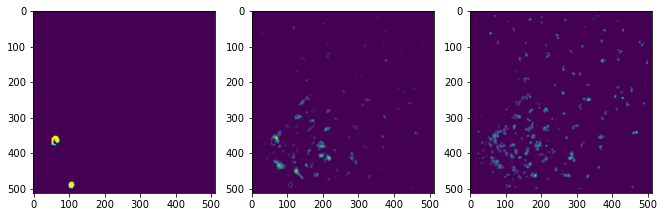

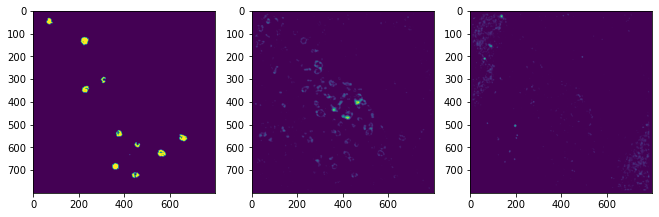

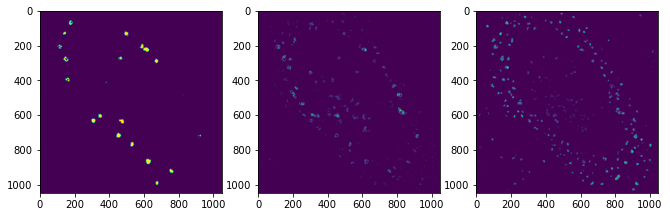

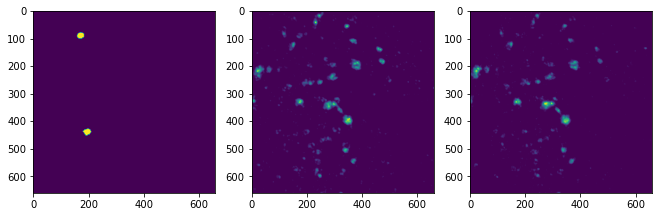

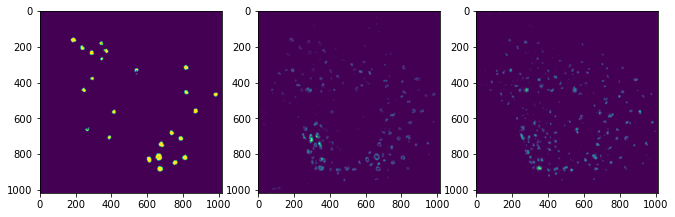

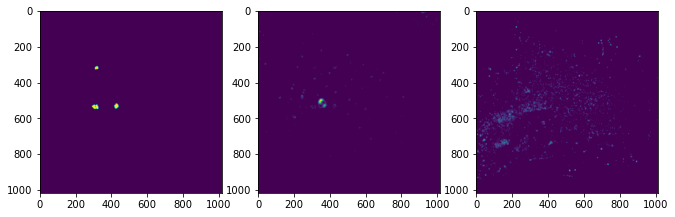

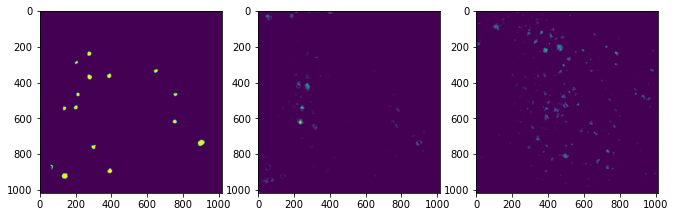

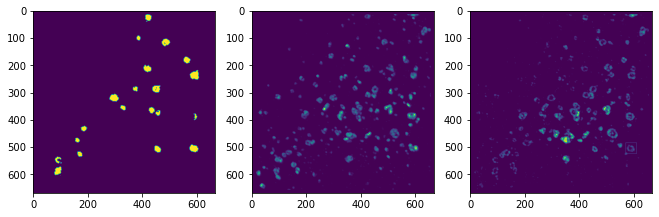

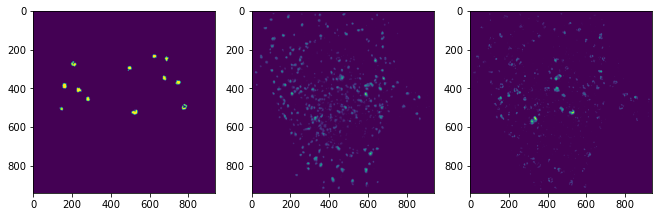

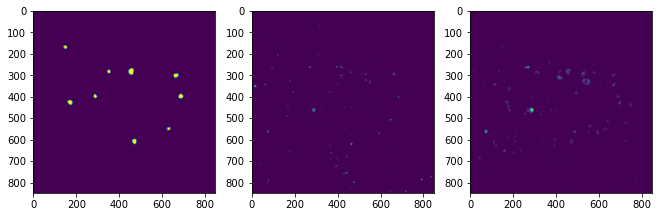

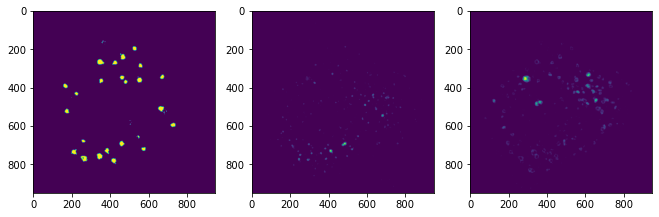

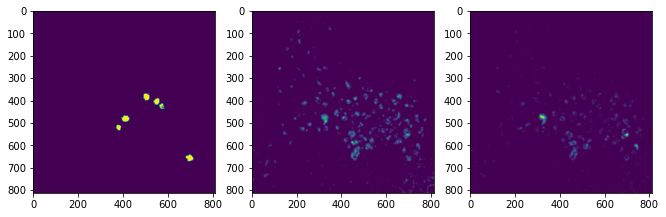

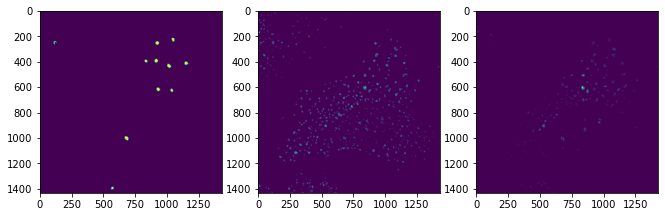

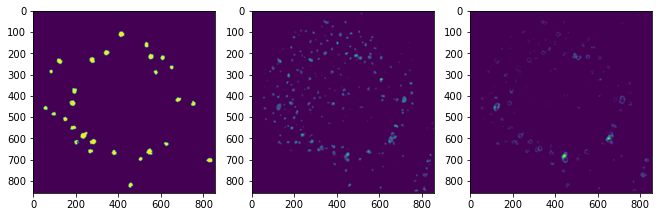

In [15]:
# show mask, raw giantin and normalzed giantin
import tensorflow as tf

for k in range(len(pred_mask) - 1):
    golgi = tf.keras.utils.normalize(golgi_image_list[k], axis=1)
    plt.figure(figsize=(15, 15))
    plt.subplot(141)
    plt.imshow(np.array(unpad_mask_list[k] > threshold, dtype=np.bool_))
    plt.subplot(142)
    plt.imshow(golgi_image_list[k][0])
    plt.subplot(143)
    plt.imshow(golgi_image_list[k][1])
    if golgi.shape[2] == 3:
        plt.subplot(144)
        plt.imshow(golgi_image_list[k][2])

    plt.show()

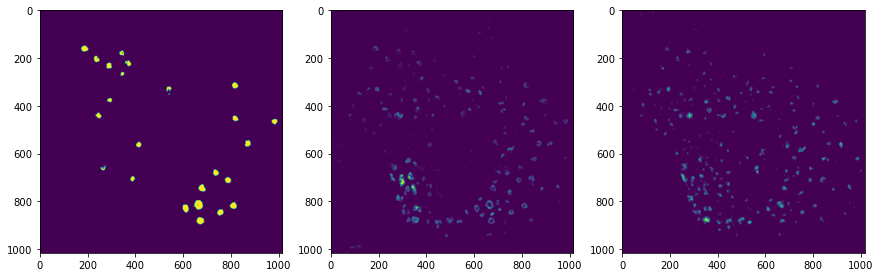

In [17]:
k = 4
golgi = tf.keras.utils.normalize(golgi_image_list[k], axis=1)
plt.figure(figsize=(20, 5))
plt.subplot(141)
plt.imshow(np.array(unpad_mask_list[k] > threshold, dtype=np.bool_))
plt.subplot(142)
plt.imshow(golgi_image_list[k][0])
plt.subplot(143)
plt.imshow(golgi_image_list[k][1])

## deal with mask

In [15]:
threshold = 0.5

../jupyter_data/eval/c1\20181025-VSVGwt-Flag-594-ST6-moxGFP-5mBiotin-Noc-03\20181025-Giantin-647-RUSH-VSVGwt-Flag-594-ST6-moxGFP-5mBiotin-Noc-03.tif


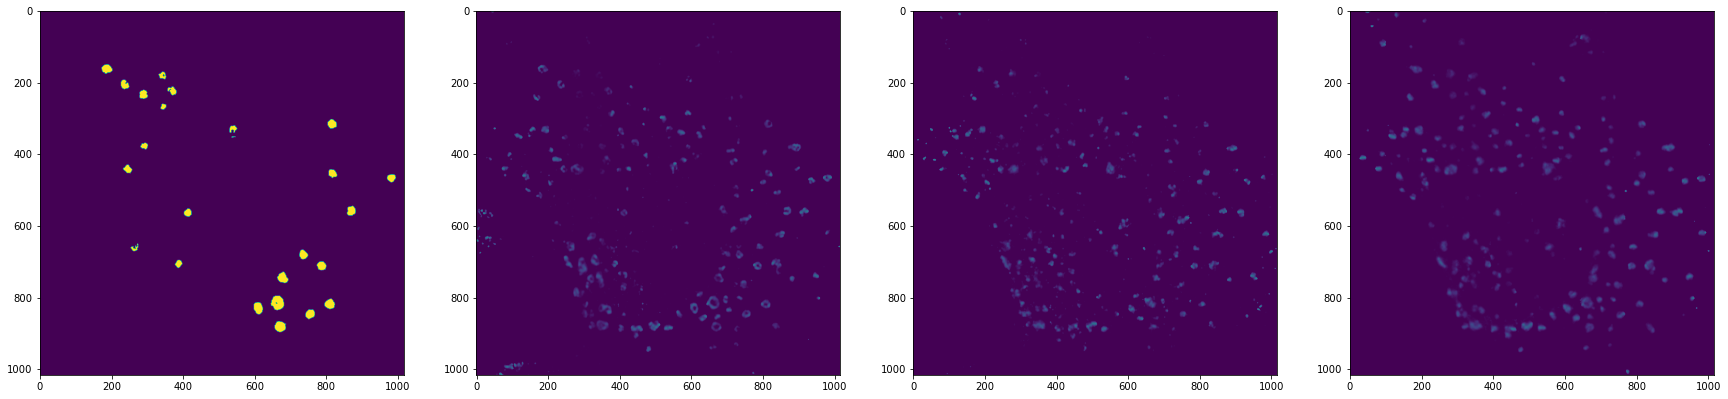

In [16]:
k = 4
print(eval_tifpath_list[k])
thres_mask = np.array(unpad_mask_list[k] > threshold, dtype=np.uint8)
golgi = tf.keras.utils.normalize(golgi_image_list[k], axis=1)
# golgi = golgi_image_list[k]
plt.figure(figsize=(30, 10))
plt.subplot(141)
plt.imshow(thres_mask)
plt.subplot(142)
plt.imshow(golgi[0])
plt.subplot(143)
plt.imshow(golgi[1])
if golgi_image_list[k].shape[0] == 3:
    plt.subplot(144)
    plt.imshow(golgi[2])

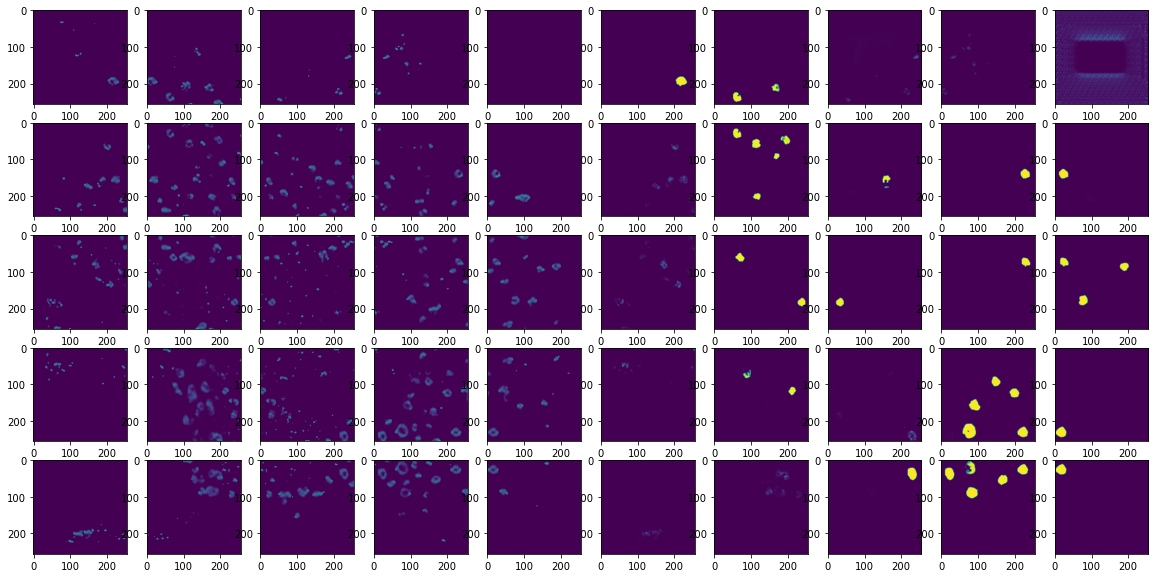

In [20]:
test_giantin_patches = tf.keras.utils.normalize(patches_giantin_list[k], axis=1)
test_pred_mask_patches = pred_mask_patches[k]
nrow = int(np.sqrt(test_giantin_patches.shape[0]))
plt.figure(figsize=(20, 10))

for i, patch in enumerate(test_giantin_patches):
    pos = i // 5 * 5 + i + 1
    plt.subplot(nrow, 2 * nrow, pos)
    plt.imshow(patch)

    plt.subplot(nrow, 2 * nrow, pos + nrow)
    plt.imshow(test_pred_mask_patches[i])

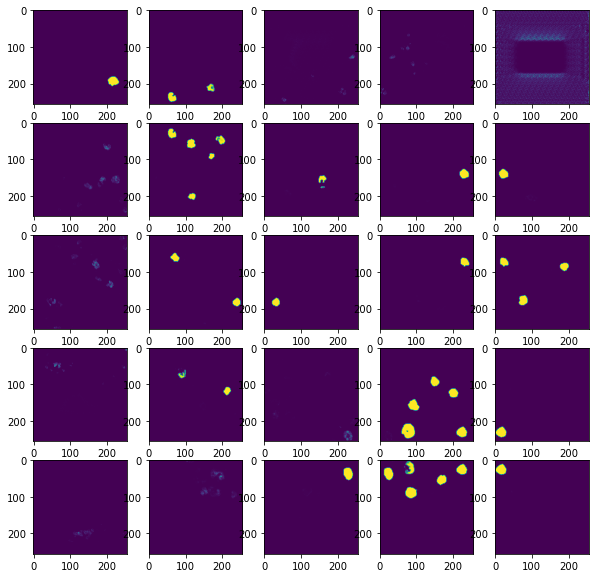

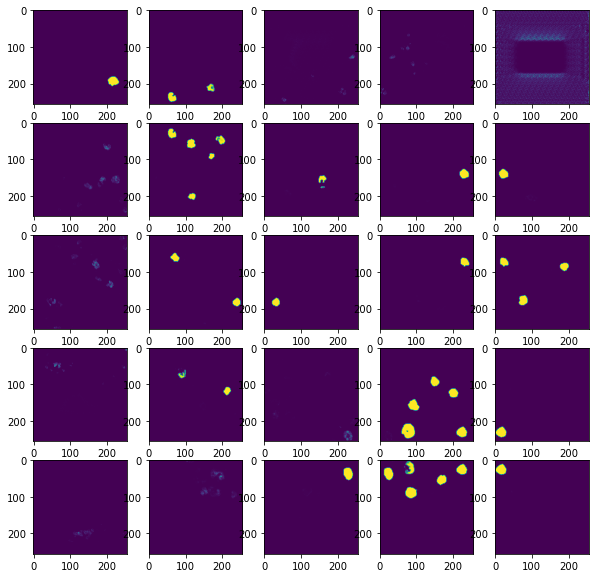

In [18]:
test_pred_mask_patches = pred_mask_patches[k]
nrow = int(np.sqrt(test_pred_mask_patches.shape[0]))
plt.figure(figsize=(10, 10))

for i, patch in enumerate(test_pred_mask_patches):
    plt.subplot(nrow, nrow, i + 1)
    plt.imshow(patch)

## find contours on mask

In [19]:
import cv2

In [20]:
contours, _ = cv2.findContours(thres_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [97]:
contour_area_threshold = 150
giantin_possibility_threshold = 0.6
giantin_channel = 0

0
655 866


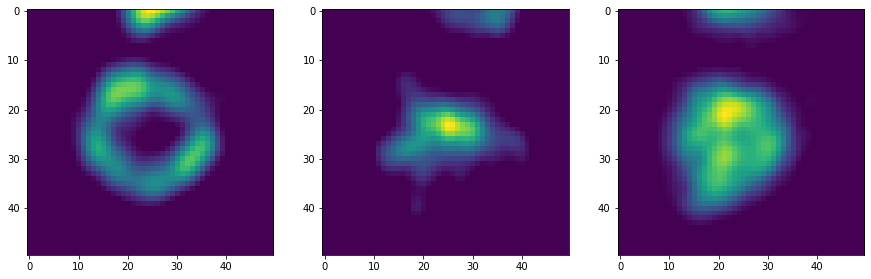

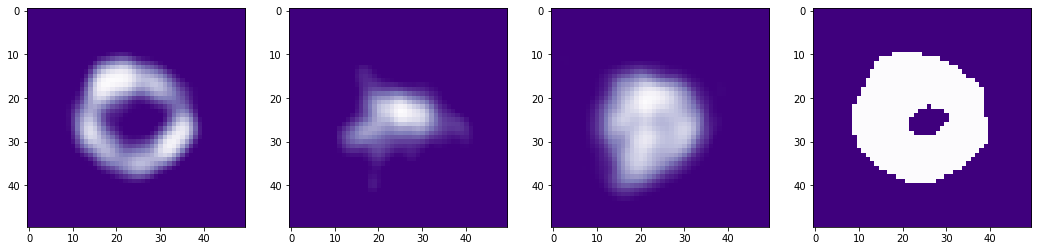

(349.5027, 349.5071)
1
741 833


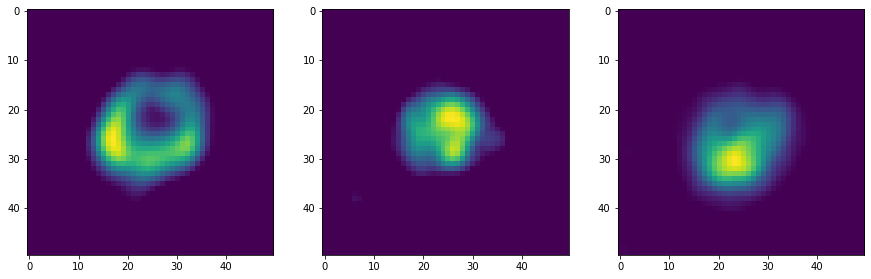

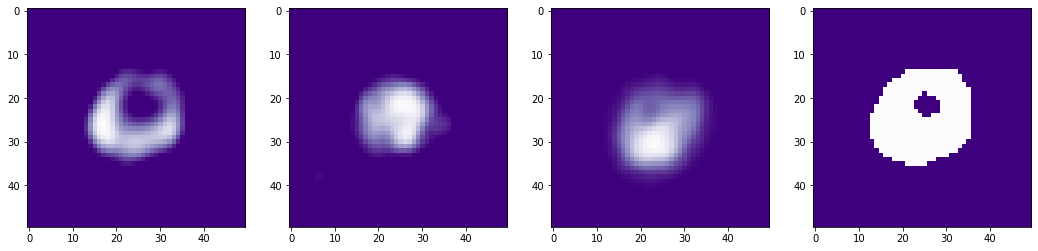

(349.5081, 349.4876)
2
597 813


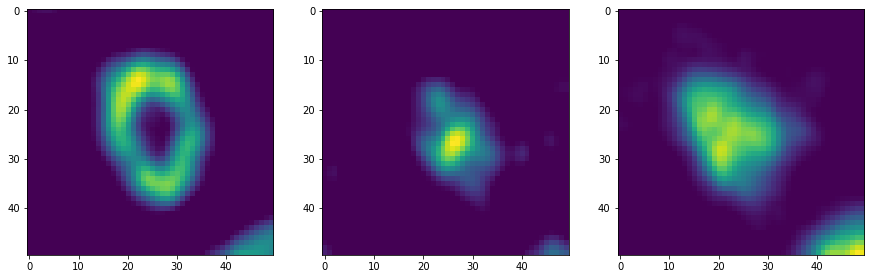

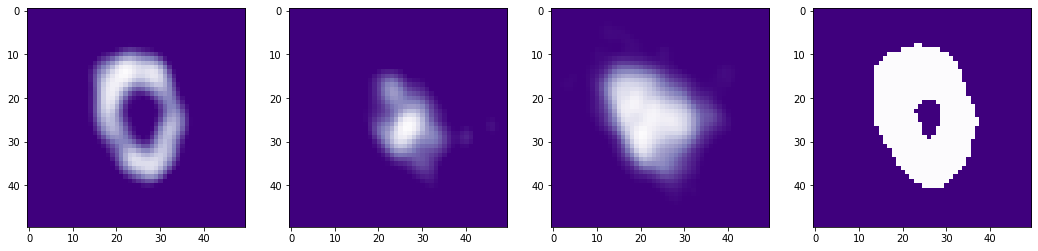

(349.511, 349.5048)
3
794 803


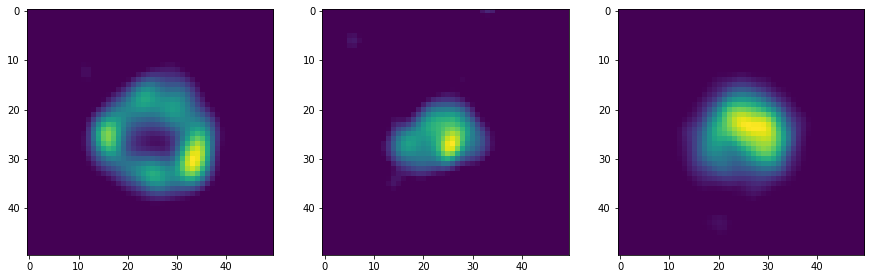

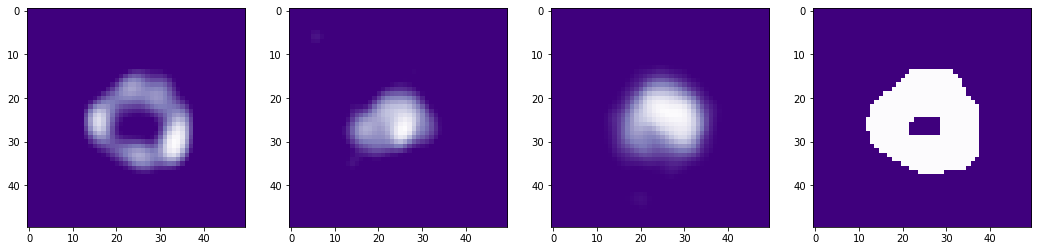

(349.5012, 349.4997)
4
644 795


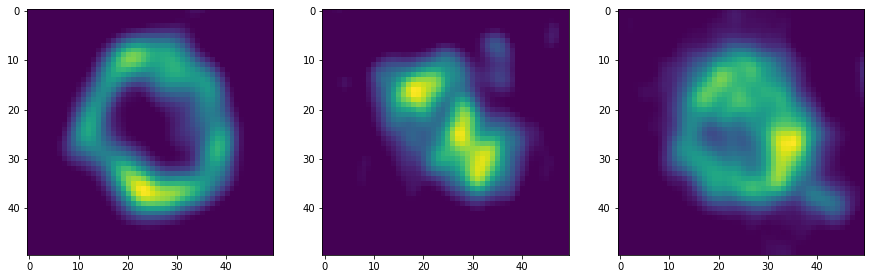

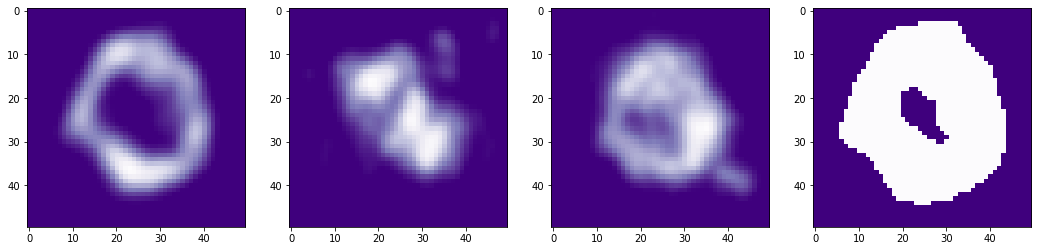

(349.5083, 349.5101)
5
662 728


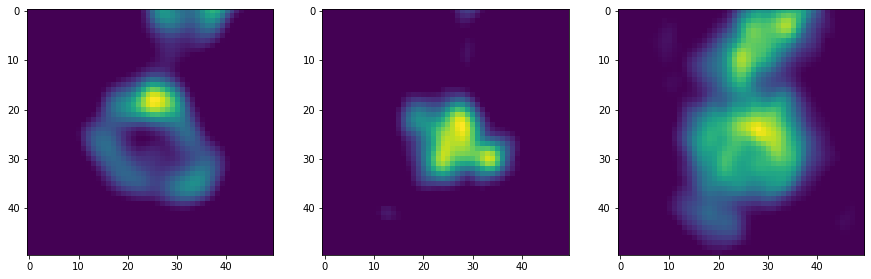

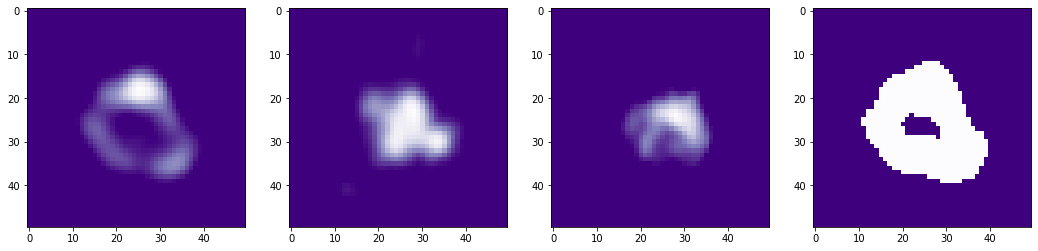

(349.5109, 349.4966)
6
773 699


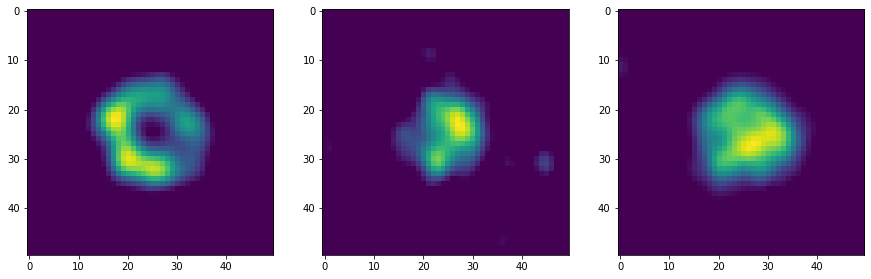

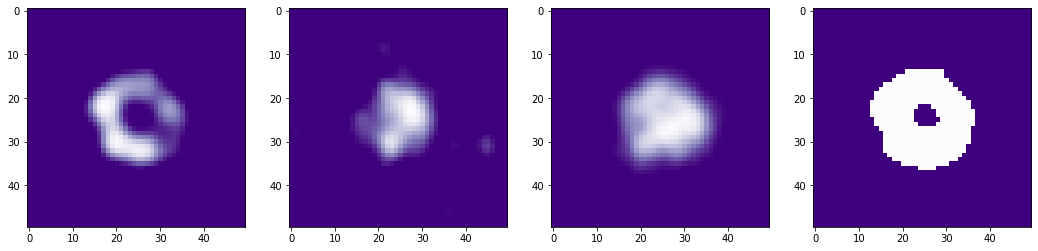

(349.5135, 349.484)
7
377 695


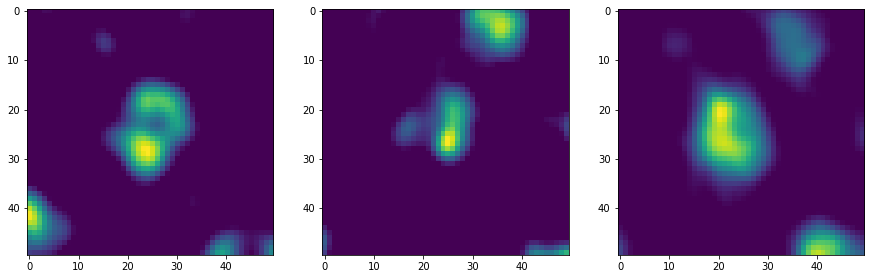

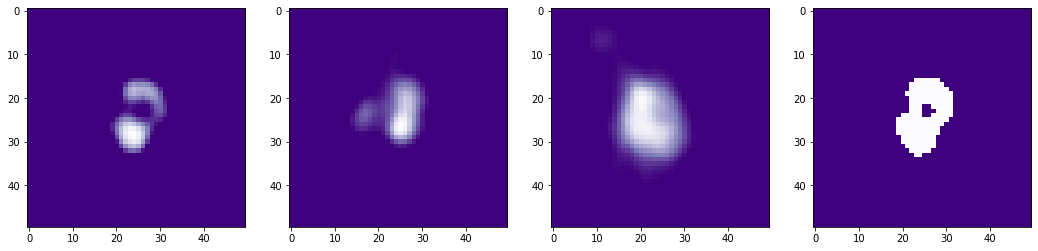

new rect_size: 37
377 695


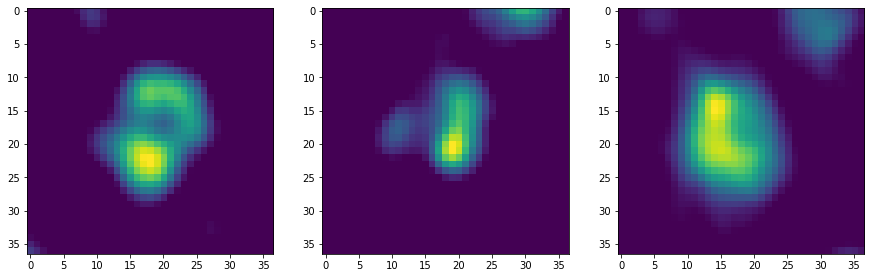

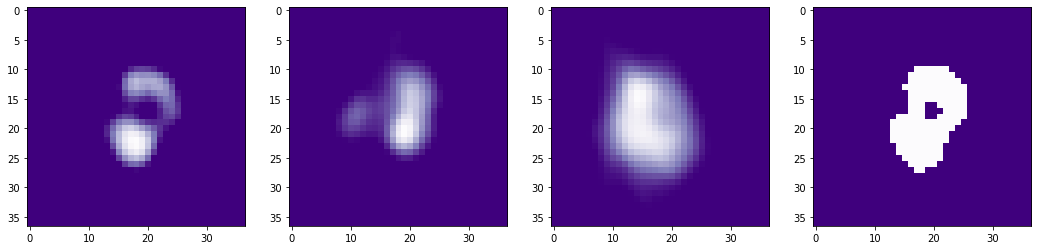

(349.5053, 349.4943)
8
724 666


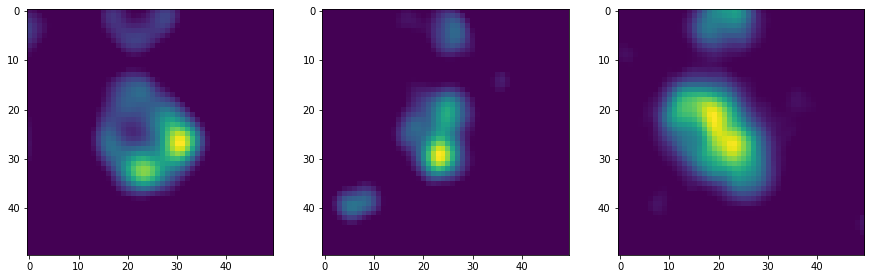

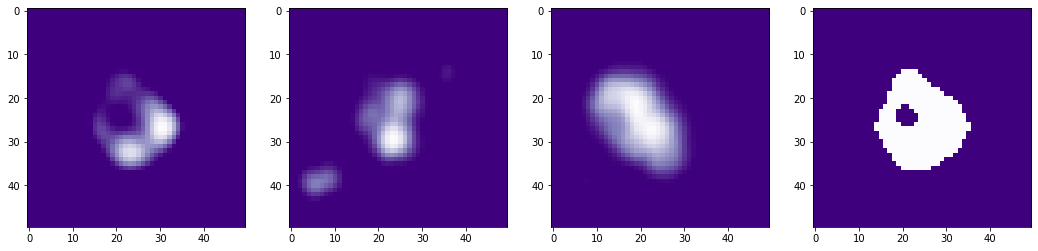

new rect_size: 44
724 666


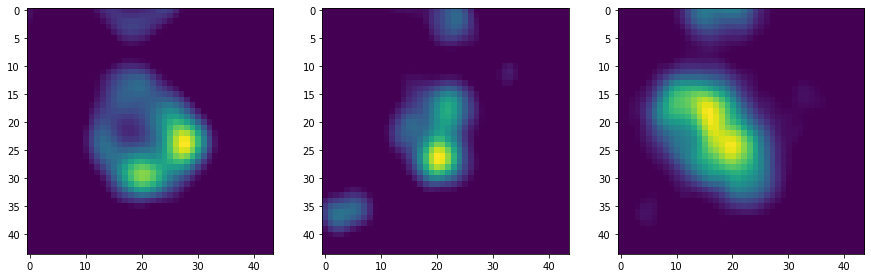

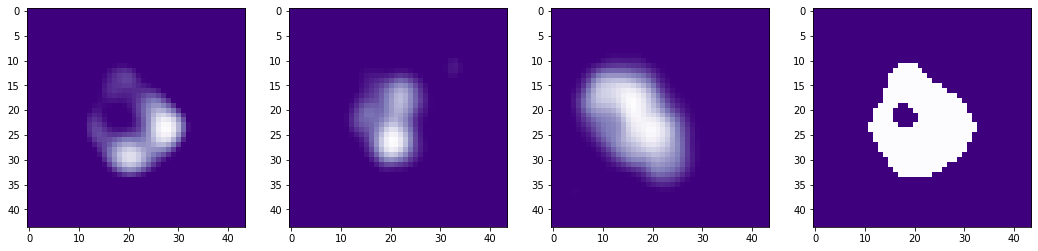

(349.494, 349.5015)
9
253 649


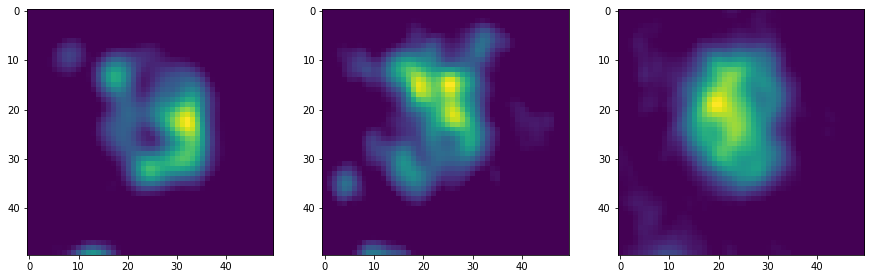

low possibility: 0.24519172310829163


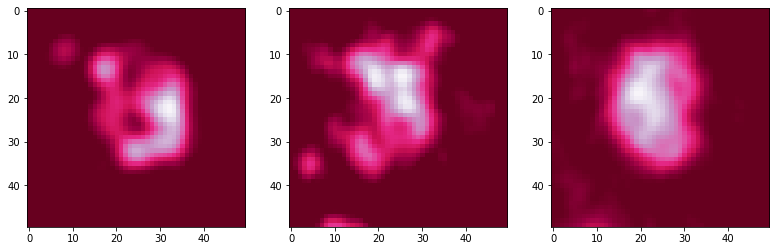

10
402 551


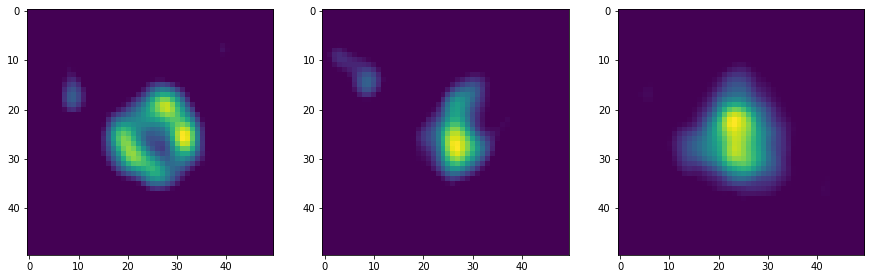

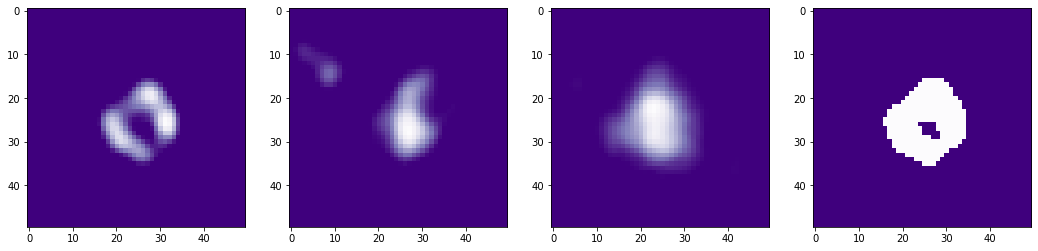

new rect_size: 44
402 551


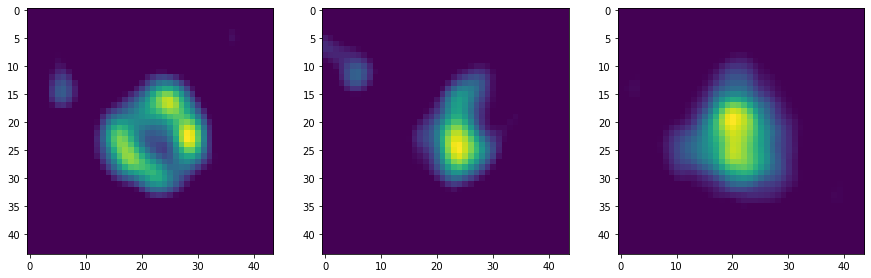

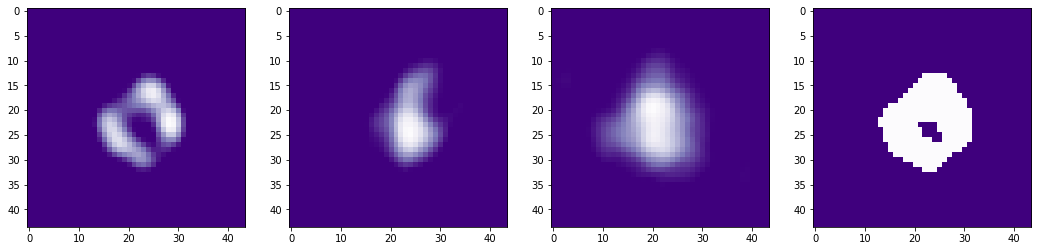

(349.5026, 349.5113)
11
857 544


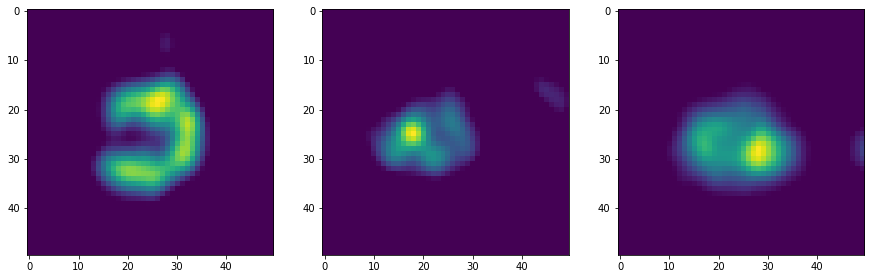

ratio larger than 1.05. 1.1176824486055026


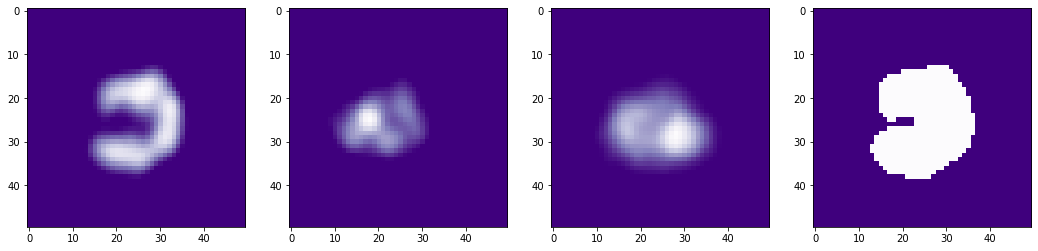

(349.4969, 349.5102)
12
969 456


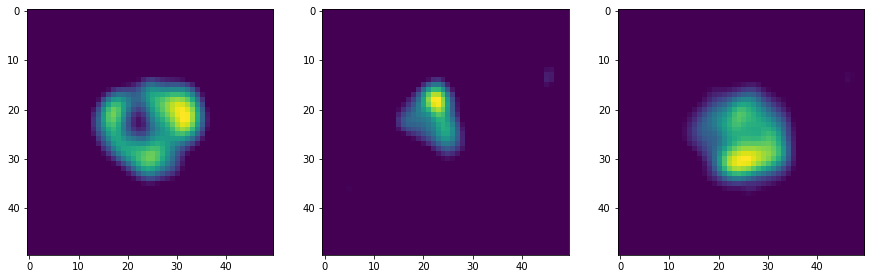

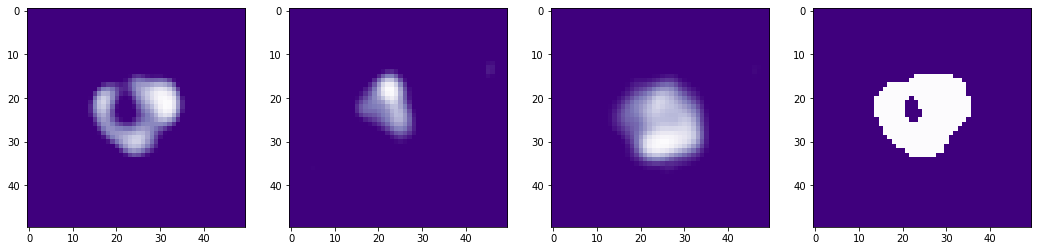

new rect_size: 48
969 456


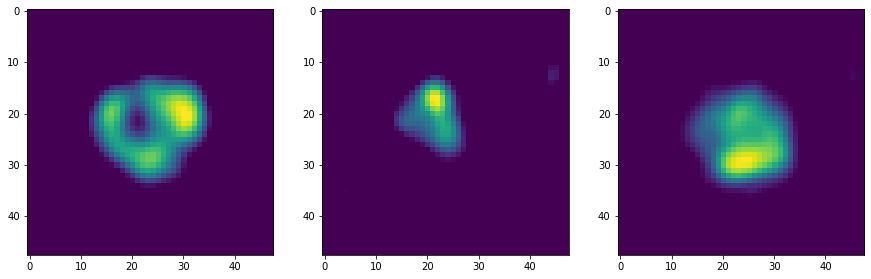

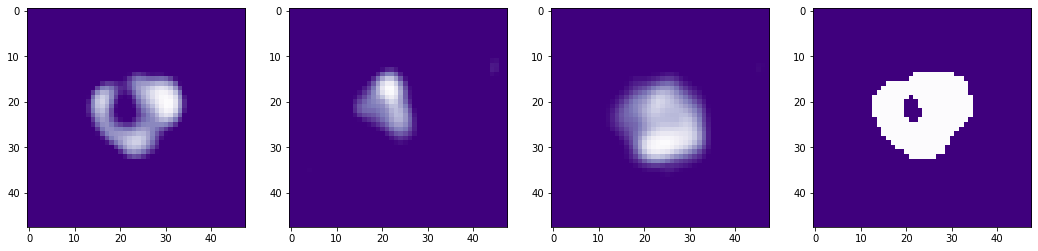

(349.4878, 349.4982)
13
806 442


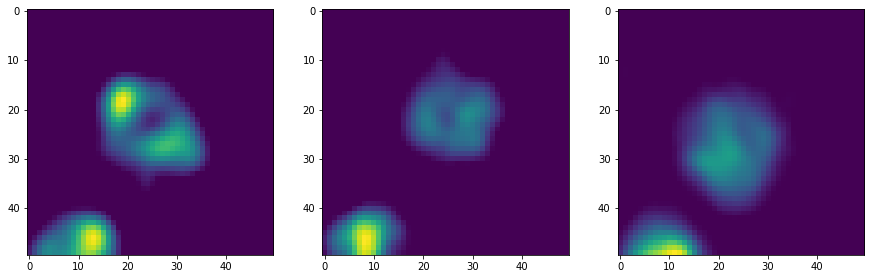

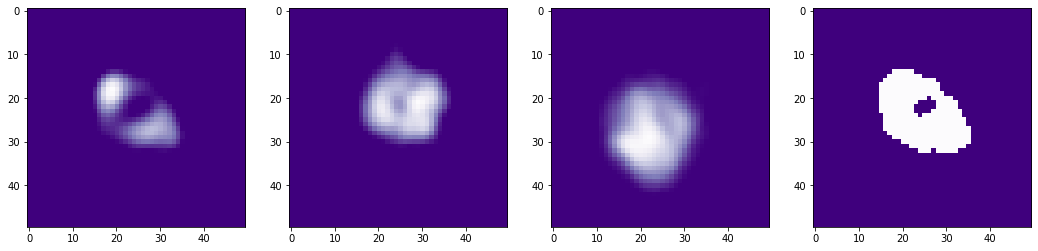

new rect_size: 49
806 442


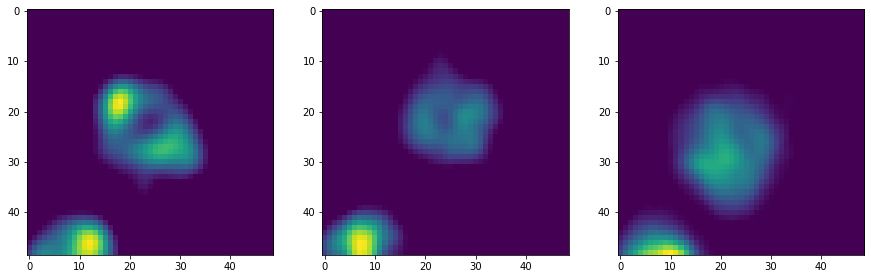

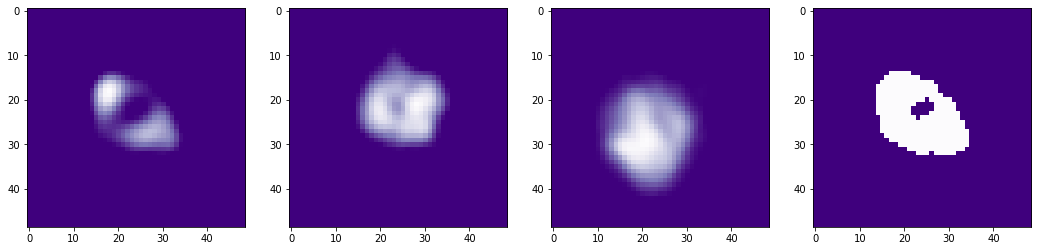

(349.4899, 349.5082)
14
232 429


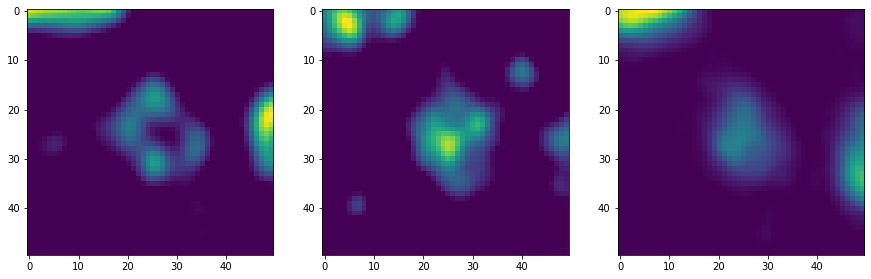

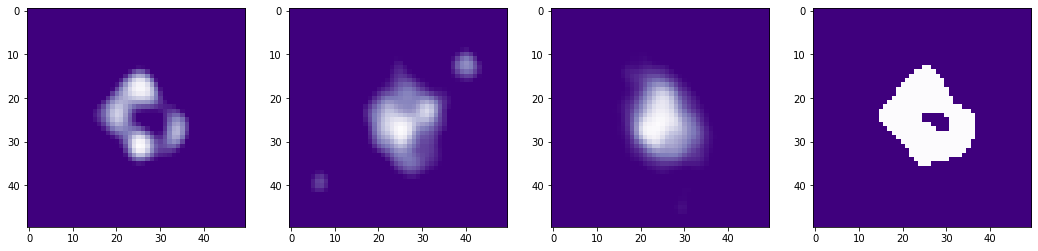

new rect_size: 49
232 429


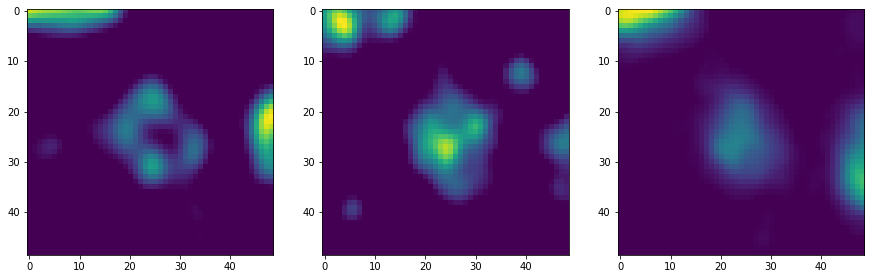

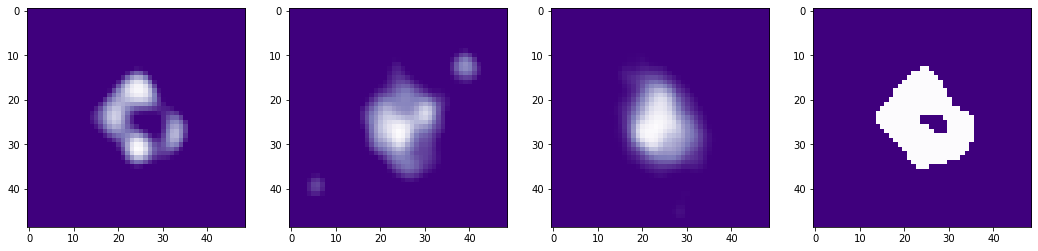

(349.4947, 349.5079)
15
280 368


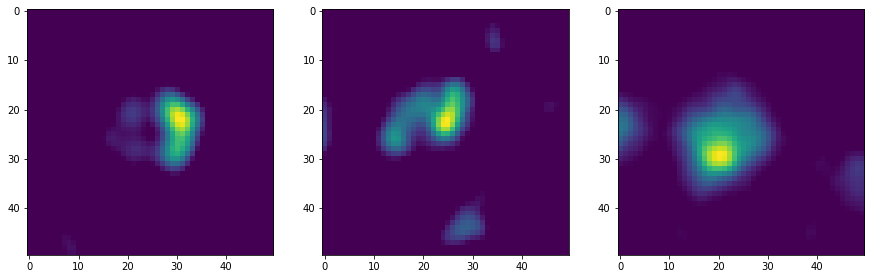

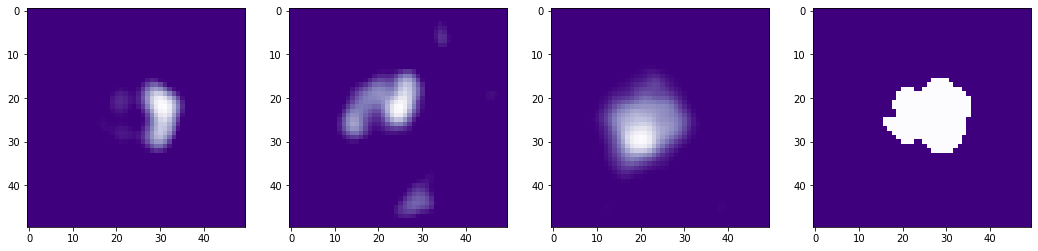

new rect_size: 32
280 368


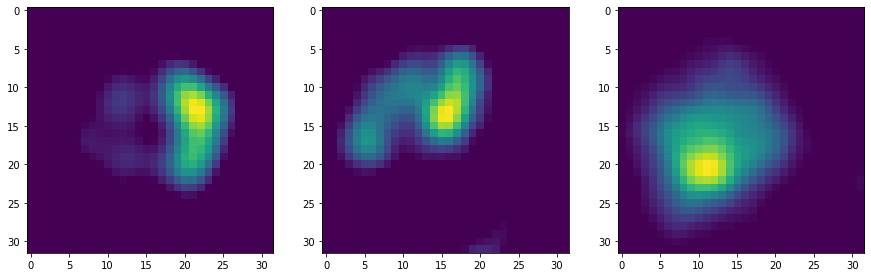

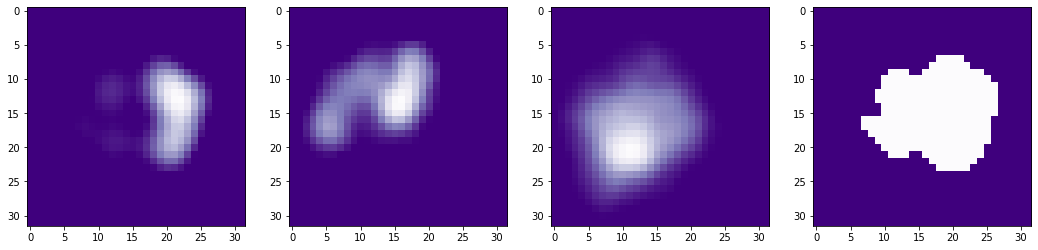

(349.507, 349.5055)
16
535 350


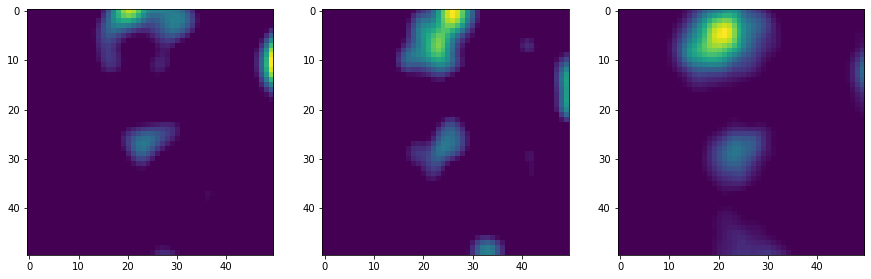

no contour in giantin channel


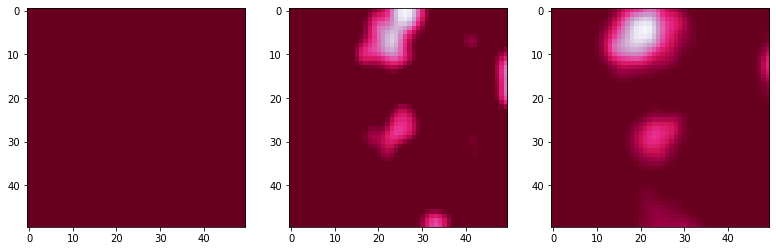

17
529 319


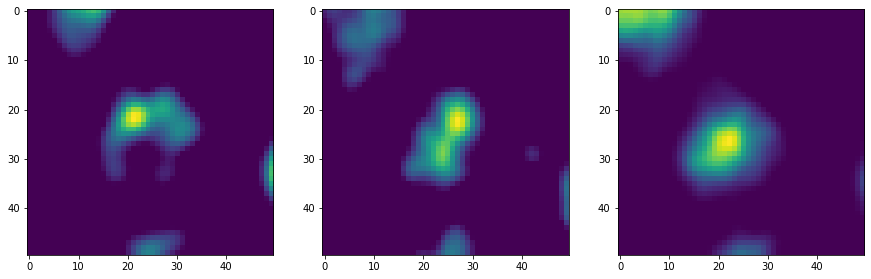

ratio larger than 1.05. 1.161707378229282


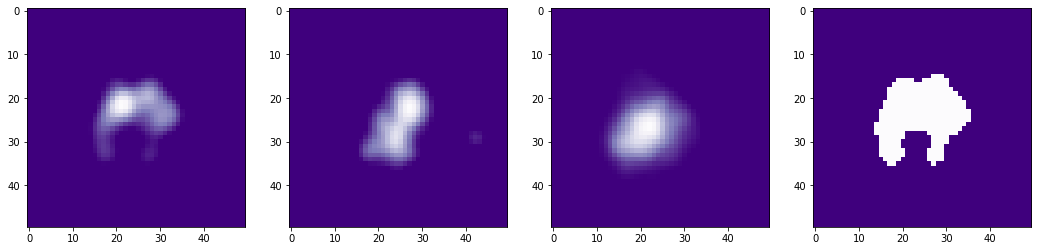

new rect_size: 41
529 319


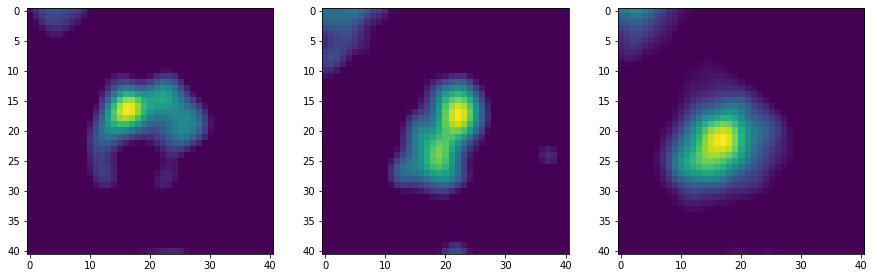

ratio larger than 1.05. 1.161707378229282


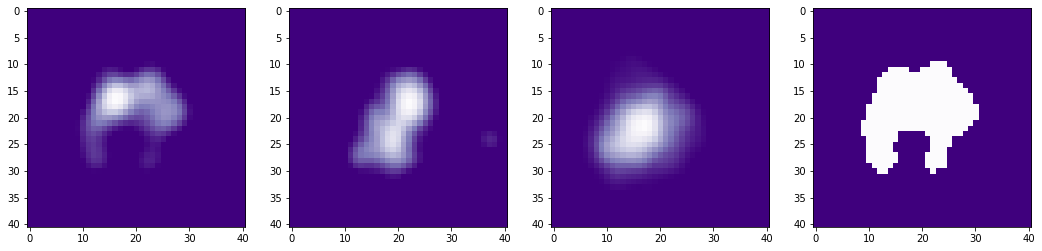

(349.4941, 349.4934)
18
803 302


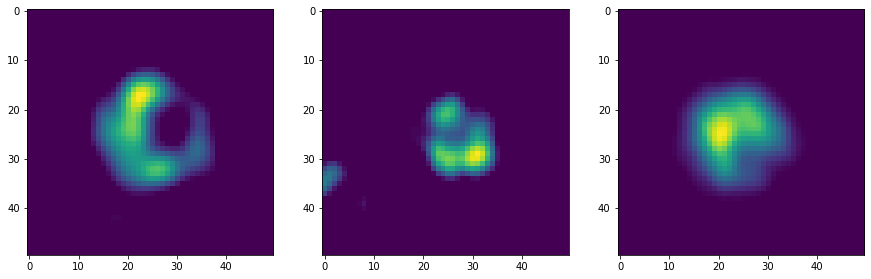

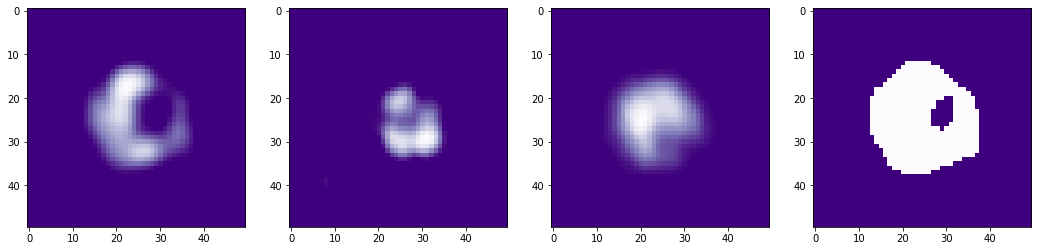

(349.5084, 349.5012)
19
337 259


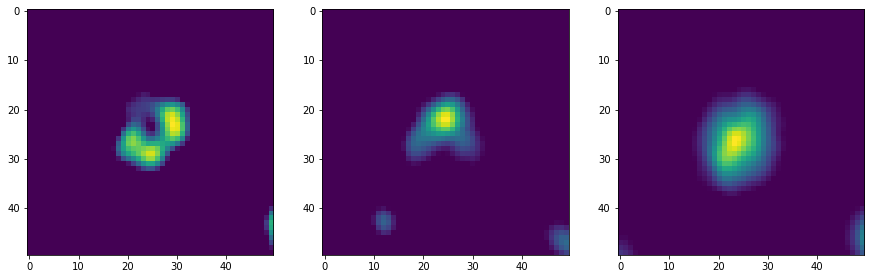

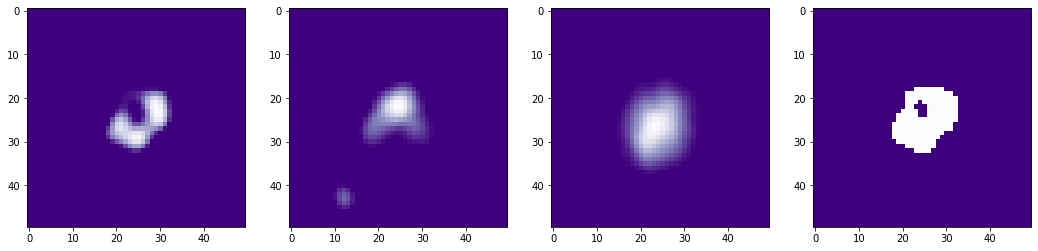

new rect_size: 34
337 259


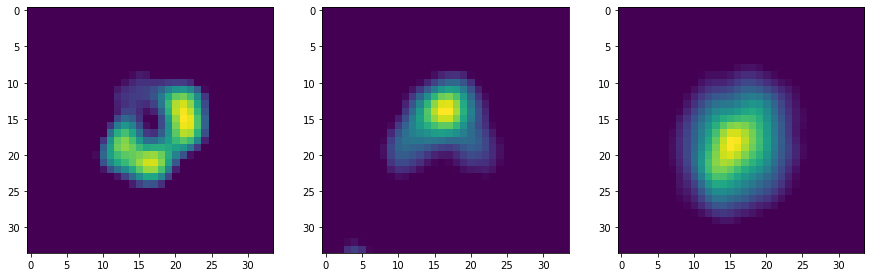

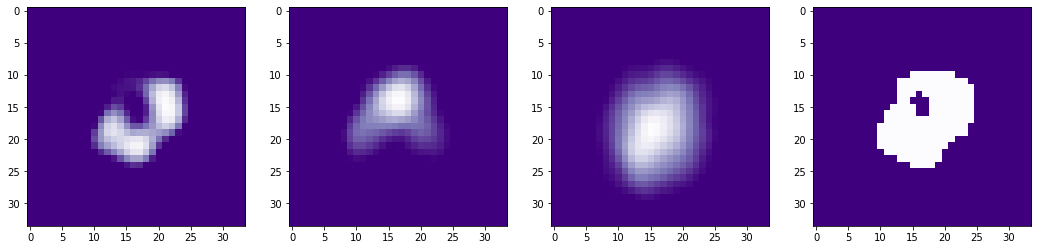

(349.5073, 349.5124)
20
278 220


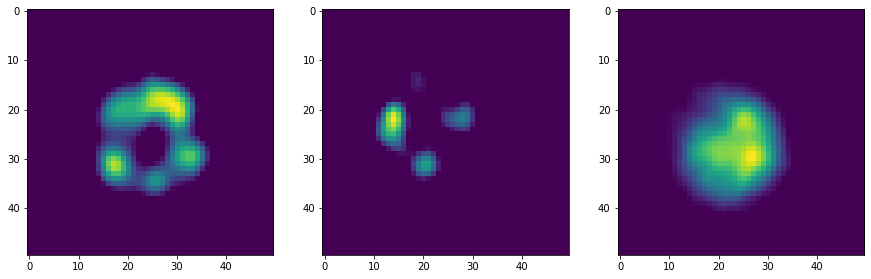

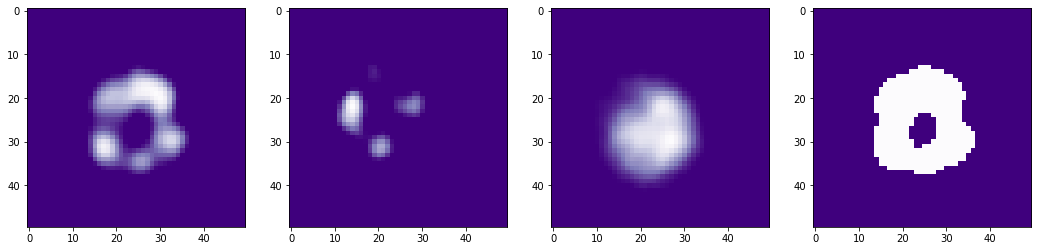

(349.4857, 349.5057)
21
356 211


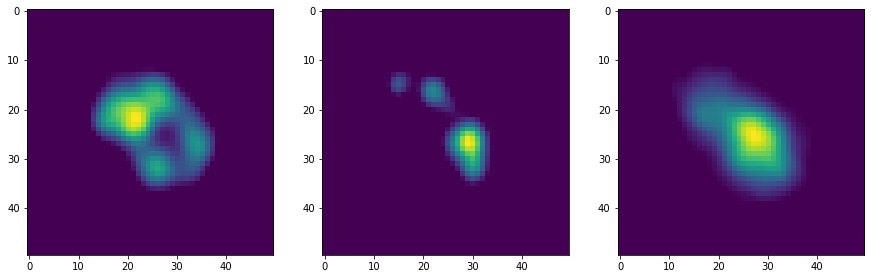

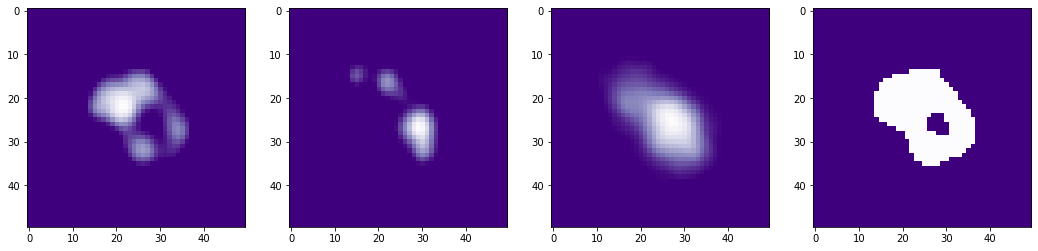

new rect_size: 48
356 211


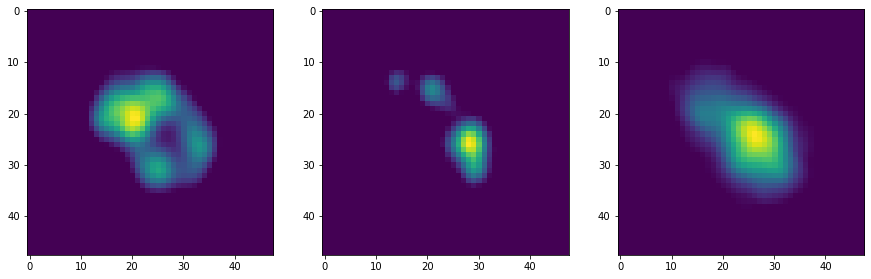

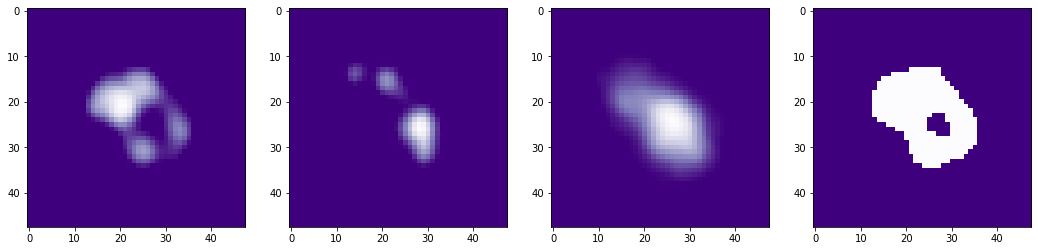

(349.502, 349.4855)
22
226 192


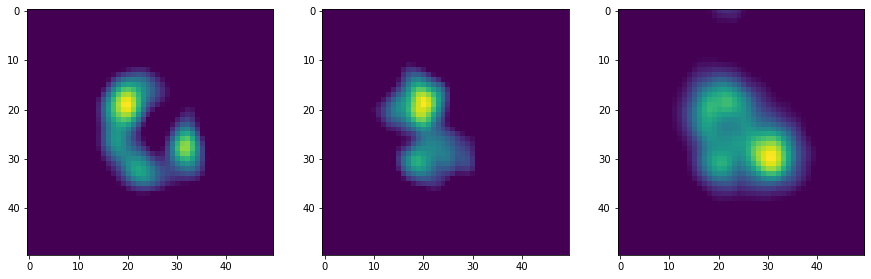

ratio larger than 1.05. 1.225253716290143


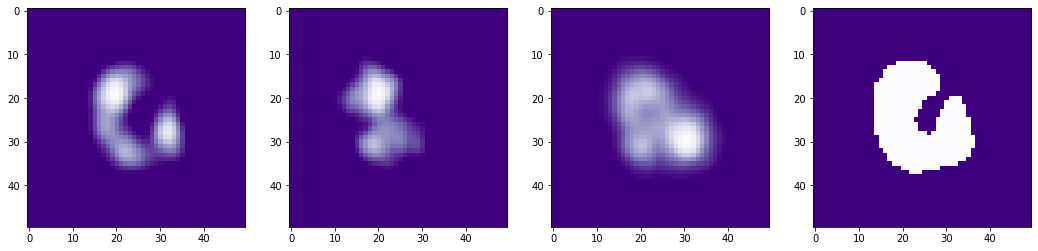

(349.4917, 349.5098)
23
331 169


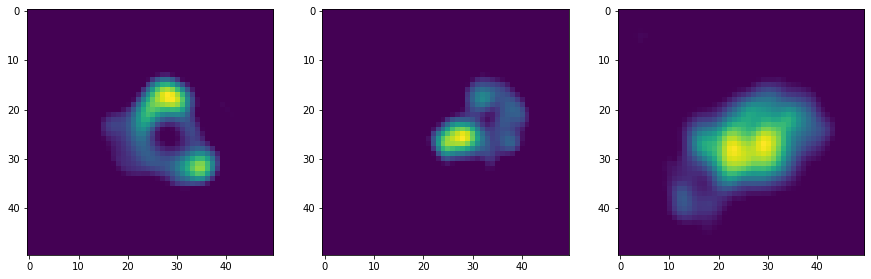

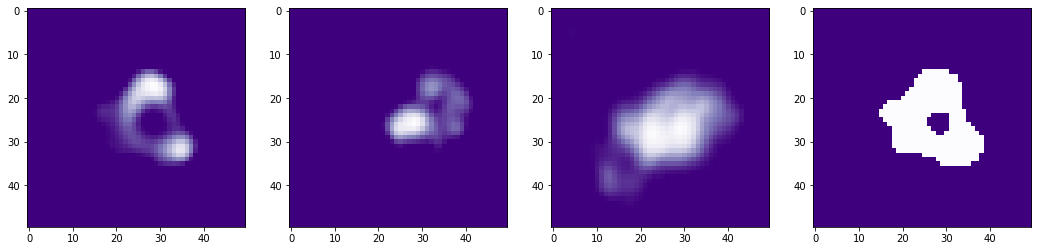

(349.5102, 349.5051)
24
172 149


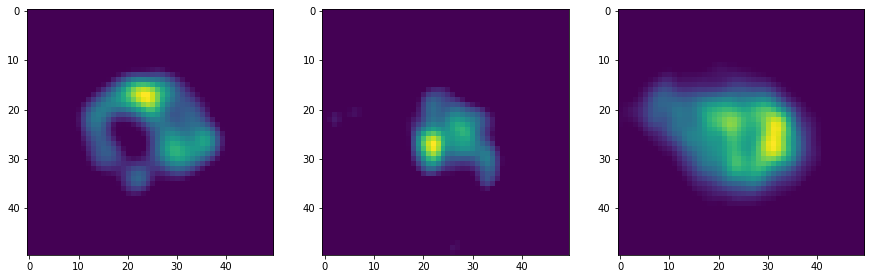

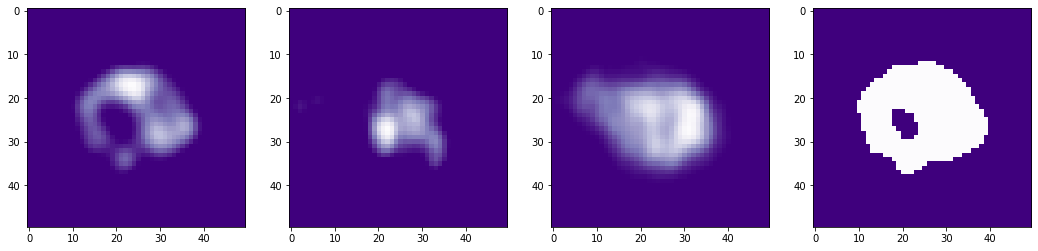

(349.4931, 349.497)


In [116]:
from functions import check_contours, cal_gyradius, cal_center_of_mass, shift_make_border, normalize_total_intensity

golgi_image = golgi_image_list[k].transpose((1, 2, 0))
pred_mask = unpad_mask_list[k]
finished_golgi_list = []
target_size = 701
center_coordinate = (350, 350)
for i, contour in enumerate(contours):
    rect_size = 50
    sub_list = None
    print(i)
    for _ in range(2):
        crop_golgi, flag, sub_list = check_contours(golgi_image, pred_mask, contour, giantin_channel=giantin_channel,
                                                    min_giantin_area=contour_area_threshold, sub_list=sub_list,
                                                    giantin_possibility_threshold=giantin_possibility_threshold,
                                                    rect_size=rect_size,
                                                    show_plt=True)
        if flag:
            crop_giantin = crop_golgi[:, :, giantin_channel]
            mx, my = cal_center_of_mass(crop_giantin)
            gyradius = cal_gyradius(crop_giantin, mx, my)
            if rect_size > gyradius * target_size / 100:
                rect_size = int(gyradius * target_size / 100)
                print("new rect_size: {}".format(rect_size))
                continue
            else:
                new_size = [int(size * 100 / gyradius) for size in crop_giantin.shape]
                resized_golgi = cv2.resize(crop_golgi, new_size, interpolation=cv2.INTER_LINEAR)
                normalized_golgi = normalize_total_intensity(resized_golgi, target_total_intensity=200000000)
                shifted_golgi = shift_make_border(normalized_golgi, border_size=(target_size, target_size),
                                                  center_coord=center_coordinate, giantin_channel=giantin_channel)
                finished_golgi_list.append(shifted_golgi)
                break
        else:
            break

In [95]:
import cv2

ret = cv2.moments(crop_giantin)
cv2.minEnclosingCircle()
print(ret)
print(ret['m10'] / ret['m00'], ret['m01'] / ret['m00'])

error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'minEnclosingCircle'
> Overload resolution failed:
>  - minEnclosingCircle() missing required argument 'points' (pos 1)
>  - minEnclosingCircle() missing required argument 'points' (pos 1)


In [344]:
ret['m10'] / ret['m00'], ret['m01'] / ret['m00']

(18.117129857438414, 15.819620240079061)

In [35]:
tifffile.imsave(data=crop_golgi, file="test_crop_golgi.tif")

In [129]:
finished_golgi_list = np.array(finished_golgi_list)

In [136]:
mean_golgi = np.mean(finished_golgi_list, axis=0)
print(mean_golgi.shape)

(701, 701, 3)


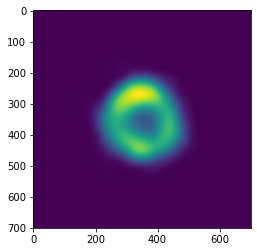

In [131]:
plt.imshow(mean_golgi)

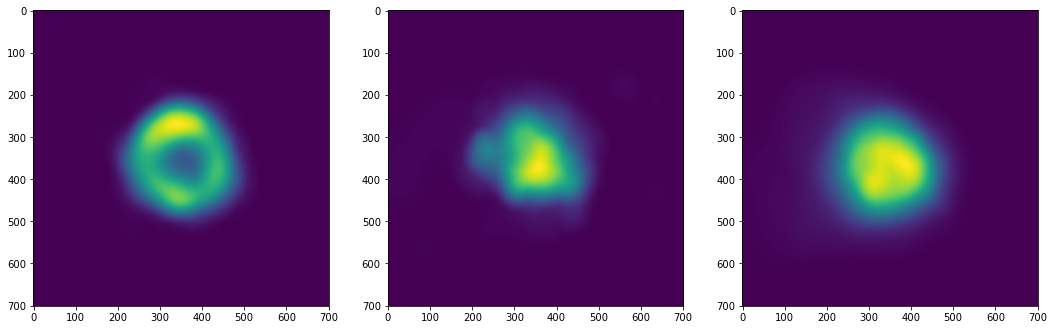

In [138]:
fig = mean_golgi
plt.figure(figsize=(18, 10))
plt.subplot(131)
plt.imshow(fig[:, :, 0])
plt.subplot(132)
plt.imshow(fig[:, :, 1])
plt.subplot(133)
plt.imshow(fig[:, :, 2])
plt.show()

377 695


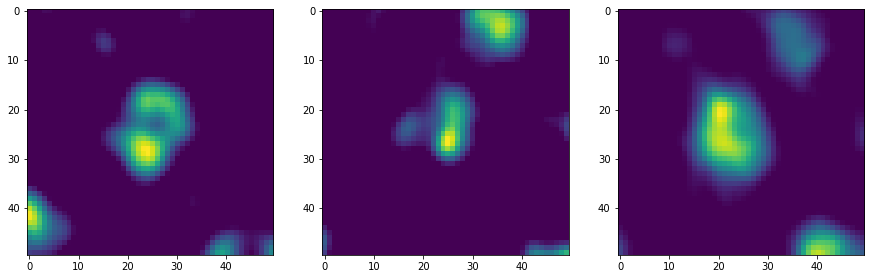

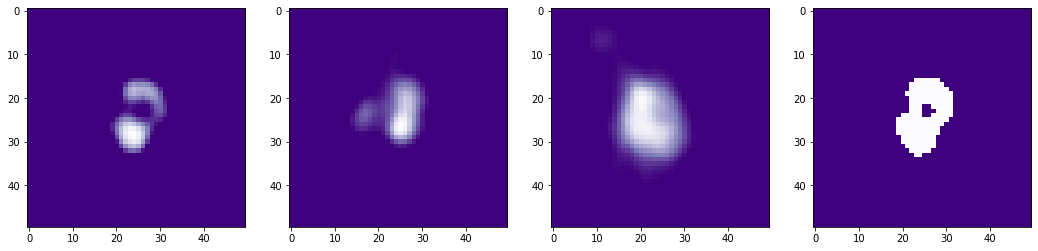

377 695


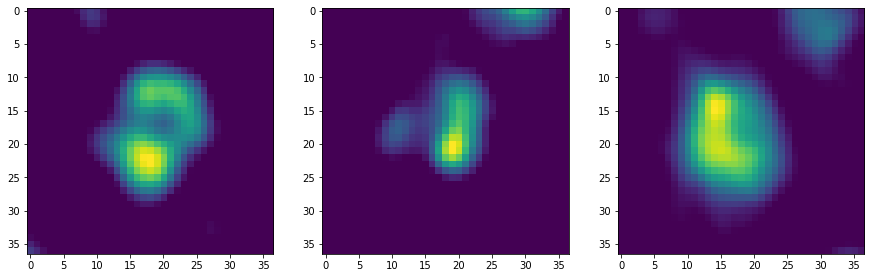

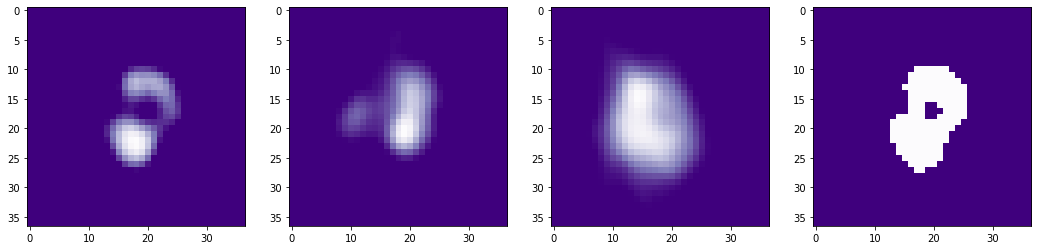

(349.5053, 349.4943)


In [115]:
from functions import check_contours, cal_gyradius, cal_center_of_mass, shift_make_border, normalize_total_intensity

golgi_image = golgi_image_list[k].transpose((1, 2, 0))
pred_mask = unpad_mask_list[k]
target_size = 701
center_coordinate = (350, 350)
rect_size = 50
sub_list = None
for _ in range(2):
    crop_golgi, flag, sub_list = check_contours(golgi_image, pred_mask, contours[7], giantin_channel=giantin_channel,
                                                min_giantin_area=contour_area_threshold,
                                                giantin_possibility_threshold=giantin_possibility_threshold,
                                                rect_size=rect_size, sub_list=sub_list,
                                                show_plt=True)
    if flag:
        crop_giantin = crop_golgi[:, :, giantin_channel]
        mx, my = cal_center_of_mass(crop_giantin)
        gyradius = cal_gyradius(crop_giantin, mx, my)
        if rect_size > gyradius * target_size / 100:
            rect_size = int(gyradius * target_size / 100)
            continue
        new_size = [int(size * 100 / gyradius) for size in crop_giantin.shape]
        resized_golgi = cv2.resize(crop_golgi, new_size, interpolation=cv2.INTER_LINEAR)
        normalized_golgi = normalize_total_intensity(resized_golgi, target_total_intensity=200000000)
        shifted_golgi = shift_make_border(normalized_golgi, border_size=(target_size, target_size),
                                          center_coord=center_coordinate, giantin_channel=giantin_channel)
        finished_golgi_list.append(shifted_golgi)
        break
    else:
        break